In [1]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
# Needed if pycharm doesn't include source package in system path
# a=True
# import sys
# if a:
#     sys.path.append("..")
#     print(sys.path)
#     a=False

In [3]:
# Load imports
from river import metrics
from river.utils import Rolling
from river.ensemble import AdaptiveRandomForestRegressor
from river.datasets import Bikes
from river import preprocessing
from river import compose
from ixai.explainer import IncrementalPFI, IncrementalSage, IncrementalPDP
from ixai.utils.wrappers import RiverWrapper
from ixai.storage import GeometricReservoirStorage
from ixai.imputer import MarginalImputer

In [4]:
# Set config variables
RANDOM_SEED = 42

In [5]:
# Load stream
stream = Bikes()

In [6]:
# Printing an observation from this stream
for n, (x,y) in enumerate(stream):
    if n>0:
        break
    print(x)
    print(y)

{'moment': datetime.datetime(2016, 4, 1, 0, 0, 7), 'station': 'metro-canal-du-midi', 'clouds': 75, 'description': 'light rain', 'humidity': 81, 'pressure': 1017.0, 'temperature': 6.54, 'wind': 9.3}
1


In [7]:
# Include features that are passed to the model - include categorical variables in feature names to pass them to the model
cat_vars = ['station', 'description']
num_vars = ['clouds','humidity','pressure','temperature','wind']
#feature_names = num_vars + ['description']
#feature_names = num_vars + cat_vars
feature_names = num_vars

In [8]:
# Model and training setup - uncomment Pipeline to use categorical variables
# model = compose.Pipeline(
#     compose.Select('description') | preprocessing.OneHotEncoder()
#     | AdaptiveRandomForestRegressor(seed=RANDOM_SEED)
#     )

model = AdaptiveRandomForestRegressor(seed=RANDOM_SEED)

In [9]:
# Use River Wrapper around model function to standardize model outputs, Initialize loss and training metric depending on ML task
model_function = RiverWrapper(model.predict_one)
loss_metric = metrics.MAE()
training_metric = Rolling(metrics.MAE(), window_size=1000)

In [10]:
# Instantiate Storage Object and Imputer
storage = GeometricReservoirStorage(
    size=500,
    store_targets=False
)

imputer = MarginalImputer(
    model_function=model_function,
    storage_object=storage,
    sampling_strategy="joint"
)

In [11]:
# Instantiate Incremental PFI Explainer
incremental_pfi = IncrementalPFI(
    model_function=model_function,
    loss_function=loss_metric,
    feature_names=feature_names,
    smoothing_alpha=0.01,
    n_inner_samples=4,
    imputer=imputer,
    storage=storage
)

In [12]:
# Instantiate Incremental SAGE Explainer
incremental_sage = IncrementalSage(
    model_function=model_function,
    loss_function=loss_metric,
    imputer=imputer,
    storage=storage,
    feature_names=feature_names,
    smoothing_alpha=0.01,
    n_inner_samples=4
)

In [13]:
# Instantiate Incremental PDP Explainer
incremental_pdp = IncrementalPDP(
    model_function=model_function,
    gridsize=8,
    dynamic_setting=True,
    smoothing_alpha=0.01,
    pdp_feature='humidity',
    storage=storage,
    storage_size=100,
    is_classification=False
)

250: perf 589.1537993539753
250: sage  {'wind': 121.17554668081729, 'temperature': 126.87195791742494, 'humidity': 142.3107327422655, 'pressure': 278.819817447031, 'clouds': 193.12359159815338}
250: pfi  {'wind': -0.0004837453281856217, 'temperature': -0.17251702544084663, 'humidity': 0.006953979040718643, 'pressure': 0.0222010965584366, 'clouds': 0.000620853267573896}

500: perf 296.3079828908009
500: sage  {'wind': 13.689416608848035, 'temperature': 12.960612469971272, 'humidity': 14.5238680914161, 'pressure': 25.480711653280103, 'clouds': 18.224292213109827}
500: pfi  {'wind': -0.1061780313152599, 'temperature': 0.13554769057071042, 'humidity': 0.0024024094418181635, 'pressure': 0.0030047989904890735, 'clouds': 0.03057845183018351}

750: perf 198.84189102423804
750: sage  {'wind': 1.1731486579242527, 'temperature': 0.9150738386332262, 'humidity': 1.1340746626324838, 'pressure': 1.9125778471668566, 'clouds': 1.5692040920968886}
750: pfi  {'wind': 0.26732880204316367, 'temperature': 0

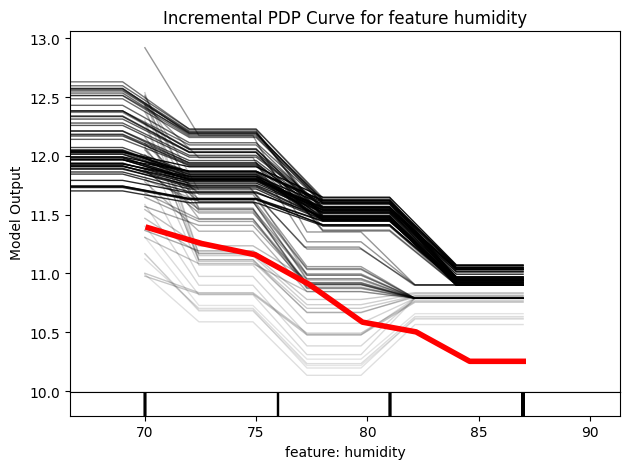

In [14]:
# Iterate over stream and explain each instance using explainers
for (n, (x_i, y_i)) in enumerate(stream, start=1):
    x_i = dict((k, x_i[k]) for k in feature_names)
    y_i_pred = model.predict_one(x_i)
    #print(y_i_pred)
    training_metric.update(y_true=y_i, y_pred=y_i_pred)

    # explaining
    inc_sage = incremental_sage.explain_one(x_i, y_i)
    inc_fi_pfi = incremental_pfi.explain_one(x_i, y_i, update_storage=False)
    inc_pdp = incremental_pdp.explain_one(x_i, update_storage=False)

    # learning
    model.learn_one(x_i, y_i)
    #print("Here")
    if n % 250 == 0:
        print(f"{n}: perf {training_metric.get()}\n"
              f"{n}: sage  {incremental_sage.importance_values}\n"
              f"{n}: pfi  {incremental_pfi.importance_values}\n")

    if n >= 1000:
        incremental_pdp.plot_pdp()
        break

In [ ]:
# Check if pipeline is working as expected
# x, y = next(iter(stream))
# print(model.debug_one(x))